### Imports

In [1]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import polars as pl
import numpy as np
import yfinance as yf

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Data Extraction 

In [2]:
# Set Data Extraction parameters for trading with Polars
start_date = "2019-01-01"  # Start date for historical data
end_date = "2024-06-01"    # End date for historical data (adjust as needed)

# File paths for storing and retrieving data
file_name = "data/raw_data_etf.csv"  # Path for ETF data
file_name_coint = "data/raw_data_coint_pairs.csv"  # Path for cointegrated pairs data

# Flags for data loading
load_existing = True     # Set to True to load existing ETF data from file
load_coint_pairs = False   # Set to True to load existing cointegrated pairs data

# Note: When using Polars for trading:
# - Ensure date parsing is handled correctly when reading/writing CSV files
# - Consider using Polars' memory-efficient data types for large datasets
# - Leverage Polars' fast I/O operations for reading/writing data
# - Utilize Polars' vectorized operations for quick data manipulations

### Get Symbols

In [3]:
import yfinance as yf  # Import the yfinance library for financial data
import polars as pl    # Import the Polars library for DataFrame operations
import pandas as pd    # Import the pandas library for data manipulation

# Variable to determine whether to load existing data or fetch new data
load_existing = True

# Function to fetch NASDAQ symbols
def get_nasdaq_symbols():
    # URL of the NASDAQ listed symbols file
    url = 'ftp://ftp.nasdaqtrader.com/SymbolDirectory/nasdaqlisted.txt'
    # Read the symbols data from the URL using pandas
    symbols = pd.read_csv(url, sep='|')
    # Drop rows with any missing values
    symbols = symbols.dropna()
    # Set the 'Symbol' column as the index of the DataFrame
    symbols.set_index('Symbol', inplace=True)
    # Return the DataFrame containing the symbols
    return symbols

# Function to load existing symbols from a file
def load_existing_symbols(file_path):
    # Read the symbols from a CSV file
    existing_symbols = pd.read_csv(file_path)
    # Set the 'Symbol' column as the index of the DataFrame
    existing_symbols.set_index('Symbol', inplace=True)
    # Return the DataFrame containing the existing symbols
    return existing_symbols

# Path to the file where existing symbols are stored
existing_symbols_file = 'data/existing_symbols.csv'

# Check if we should load existing data or fetch new data
if load_existing:
    # Load existing symbols from the file
    existing_symbols = load_existing_symbols(existing_symbols_file)
    # Ensure symbols variable is defined when loading existing data
    symbols = existing_symbols.copy()
else:
    # Fetch the NASDAQ symbols using the defined function
    symbols = get_nasdaq_symbols()
    # Filter the symbols to include only those that are ETFs (ETF == 'Y') and belong to the NASDAQ Global Market (Market Category == 'G')
    symbols = symbols[(symbols['ETF'] == 'Y') & (symbols['Market Category'] == 'G')]
    # Convert the filtered symbols DataFrame index to a list of symbol strings
    new_symbols = list(symbols.index.values)

    # Compare new symbols with existing symbols (if they exist)
    try:
        existing_symbols = load_existing_symbols(existing_symbols_file)
        existing_symbols_list = list(existing_symbols.index.values)

        if new_symbols != existing_symbols_list:
            # If there are new or updated symbols, replace the existing symbols
            symbols.to_csv(existing_symbols_file)
            print("Symbols updated.")
        else:
            print("No new symbols.")
    except FileNotFoundError:
        # If the existing symbols file does not exist, save the new symbols
        symbols.to_csv(existing_symbols_file)
        print("Symbols saved.")

    # Print the list of new symbols
    print(new_symbols)

# Print the length of the symbols DataFrame
print(len(symbols))


644


In [4]:
print(len(symbols))

644


In [5]:
import yfinance as yf  
import pandas as pd   

# Ensure symbols is a list of strings, somehow errored because it was not in string format
if isinstance(symbols, pd.DataFrame):
    symbols = symbols.index.tolist()

# Fetch adjusted close prices for the symbols from Yahoo Finance
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Save the data to a CSV file
data.to_csv(file_name)

print(f"Data saved to {file_name}")


[*********************100%%**********************]  644 of 644 completed


19 Failed downloads:
['QQQT', 'BSJW', 'IBGK', 'IBGA', 'BGRO', 'METU', 'AIPI', 'GLOW', 'QBUF', 'FCTE', 'BELT', 'IBTP', 'TMET', 'BMDL', 'BSCY', 'METD', 'BRHY', 'EVSD', 'QXQ']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1717214400")



Data saved to data/raw_data_etf.csv


In [6]:
import polars as pl

# Load (or re-load for consistency) Data and remove features with NaN's
data = pl.read_csv(file_name)

# Filter columns that have all null values
data = data.filter(~pl.all_horizontal(pl.all().is_null()))

# Replace null values with zero for each column explicitly
data = data.with_columns(
    [pl.col(column).fill_null(0) for column in data.columns]
)

# Print the shape of the dataset
print("Shape:", data.shape)

# Check for any null values and print a boolean
has_null_values = data.null_count().sum_horizontal().sum() > 0
print("Null Values:", has_null_values)

# Display the first 50 rows to verify
data


Shape: (1363, 645)
Null Values: False


Date,AADR,AAPB,AAPD,AAPU,AAXJ,ABCS,ACWI,ACWX,AGMI,AGNG,AGZD,AIA,AIPI,AIQ,AIRL,AIRR,ALTY,AMDL,AMDS,AMID,AMZD,AMZU,AMZZ,ANGL,AOTG,AQWA,ARVR,ASET,AUMI,AVXC,BABX,BBH,BDGS,BEEZ,BELT,BGRN,…,VIGI,VMBS,VMOT,VNQI,VONE,VONG,VONV,VPLS,VRIG,VSDA,VSMV,VTC,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WABF,WBND,WCBR,WCLD,WEEI,WGMI,WINC,WISE,WNDY,WOOD,WRND,WTBN,XBIL,XFIX,XT,YLDE,ZZZ
str,f64,str,str,str,f64,str,f64,f64,str,f64,f64,f64,str,f64,str,f64,f64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,f64,str,str,str,f64,…,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,str,str,f64,str,str,f64,str,str,str,str,f64,f64,str
"""2019-01-02 00:00:00""",37.611717,"""0""","""0""","""0""",57.365261,"""0""",57.852909,35.929512,"""0""",18.078403,18.813515,49.291363,"""0""",12.734489,"""0""",21.639996,8.677713,"""0""","""0""","""0""","""0""","""0""","""0""",20.298046,"""0""","""0""","""0""",22.04014,"""0""","""0""","""0""",109.191841,"""0""","""0""","""0""",43.900223,…,49.100071,45.093948,22.233303,42.919487,104.997375,31.997364,43.003807,"""0""",20.791594,25.12635,23.901337,67.175766,104.8283,39.935478,117.246971,50.260658,84.563385,57.171005,40.046917,44.070271,"""0""",70.805153,"""0""","""0""","""0""","""0""",0.0,"""0""","""0""",51.86504,"""0""","""0""","""0""","""0""",31.699696,23.761587,"""0"""
"""2019-01-03 00:00:00""",37.192047,"""0""","""0""","""0""",56.010468,"""0""",56.869759,35.594368,"""0""",18.043739,18.773775,47.861725,"""0""",12.401689,"""0""",21.451561,8.691305,"""0""","""0""","""0""","""0""","""0""","""0""",20.32082,"""0""","""0""","""0""",21.988035,"""0""","""0""","""0""",109.977737,"""0""","""0""","""0""",43.900223,…,48.399136,45.277588,22.203083,42.985462,102.711044,31.044071,42.305408,"""0""",20.800024,24.629284,23.61002,67.293098,102.631546,40.043846,115.129021,49.308144,84.382988,57.323936,39.596565,43.921257,"""0""",70.721512,"""0""","""0""","""0""","""0""",0.0,"""0""","""0""",51.638752,"""0""","""0""","""0""","""0""",30.861731,23.422529,"""0"""
"""2019-01-04 00:00:00""",38.637581,"""0""","""0""","""0""",57.85627,"""0""",58.68272,36.694344,"""0""",18.670582,18.869133,49.55212,"""0""",12.900889,"""0""",22.14579,8.808432,"""0""","""0""","""0""","""0""","""0""","""0""",20.632044,"""0""","""0""","""0""",22.378815,"""0""","""0""","""0""",115.390663,"""0""","""0""","""0""",43.982475,…,49.963425,45.120186,22.258947,43.925667,106.126747,32.249996,43.498859,"""0""",20.816906,25.235598,24.027613,67.154778,105.91288,40.027176,119.461151,51.134201,86.574852,57.469257,40.88813,45.160461,"""0""",70.554199,"""0""","""0""","""0""","""0""",0.0,"""0""","""0""",53.449047,"""0""","""0""","""0""","""0""",31.918715,23.999847,"""0"""
"""2019-01-07 00:00:00""",39.094551,"""0""","""0""","""0""",58.201794,"""0""",59.043514,36.745899,"""0""",19.003748,18.809532,49.857826,"""0""",13.145592,"""0""",22.502817,8.98833,"""0""","""0""","""0""","""0""","""0""","""0""",20.912901,"""0""","""0""","""0""",22.569866,"""0""","""0""","""0""",118.102043,"""0""","""0""","""0""",43.982475,…,50.006157,45.067699,22.428373,44.181335,107.054176,32.566971,43.737545,"""0""",20.804253,25.426777,24.244074,67.191689,106.795258,40.010494,122.378143,52.096012,87.702362,57.668095,41.015579,45.19968,"""0""",70.916695,"""0""","""0""","""0""","""0""",0.0,"""0""","""0""",53.783955,"""0""","""0""","""0""","""0""",32.404339,24.228937,"""0"""
"""2019-01-08 00:00:00""",39.364998,"""0""","""0""","""0""",58.356361,"""0""",59.476471,36.986519,"""0""",19.028782,18.908878,49.722965,"""0""",13.272842,"""0""",22.790432,9.078922,"""0""","""0""","""0""","""0""","""0""","""0""",21.049543,"""0""","""0""","""0""",22.846018,"""0""","""0""","""0""",119.781929,"""0""","""0""","""0""",43.956512,…,50.373734,45.058968,22.501638,44.527729,108.027458,32.984032,44.055794,"""0""",20.816906,25.426777,24.402819,67.234444,107.925797,40.002159,124.36129,52.890553,89.100487,57.668095,41.312984,45.411442,"""0""",71.056168,"""0""","""0""","""0""","""0""",0.0,"""0""","""0""

## Data Clean up

In [7]:
import polars as pl

def clean_data(df):
    # Function to try converting to float
    def try_float(s):
        try:
            return float(s)
        except ValueError:
            return s  # Return the original value if it can't be converted

    # Identify columns that are strings
    string_cols = [col for col, dtype in df.schema.items() if dtype == pl.String]
    
    for col in string_cols:
        # Try to convert the column to float
        df = df.with_columns(pl.col(col).apply(try_float))
        
        # Check if all values in the column are now float
        if df[col].dtype == pl.Float64:
            print(f"Column {col} successfully converted to Float64.")
        else:
            print(f"Column {col} contains non-numeric values and will remain as its original type.")

    return df

# Clean the data
cleaned_data = clean_data(data)

# Print schema to verify changes
print("\nUpdated Schema:")
print(cleaned_data.schema)

# Print the first few rows of the cleaned data
print("\nFirst few rows of cleaned data:")
print(cleaned_data.head())

# Count of float columns
float_cols = [col for col, dtype in cleaned_data.schema.items() if dtype == pl.Float64]
print(f"\nNumber of Float64 columns: {len(float_cols)}")

Column Date contains non-numeric values and will remain as its original type.
Column AAPB successfully converted to Float64.
Column AAPD successfully converted to Float64.
Column AAPU successfully converted to Float64.
Column ABCS successfully converted to Float64.
Column AGMI successfully converted to Float64.
Column AIPI successfully converted to Float64.
Column AIRL successfully converted to Float64.
Column AMDL successfully converted to Float64.
Column AMDS successfully converted to Float64.
Column AMID successfully converted to Float64.
Column AMZD successfully converted to Float64.
Column AMZU successfully converted to Float64.
Column AMZZ successfully converted to Float64.
Column AOTG successfully converted to Float64.
Column AQWA successfully converted to Float64.
Column ARVR successfully converted to Float64.
Column AUMI successfully converted to Float64.
Column AVXC successfully converted to Float64.
Column BABX successfully converted to Float64.
Column BDGS successfully conv

/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df 

Column CLOD successfully converted to Float64.
Column CLSM successfully converted to Float64.


/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col(col).apply(try_float))
/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/3318089774.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  df 

Column CONL successfully converted to Float64.
Column COPJ successfully converted to Float64.
Column COPP successfully converted to Float64.
Column COWG successfully converted to Float64.
Column COWS successfully converted to Float64.
Column CPLS successfully converted to Float64.
Column CTEC successfully converted to Float64.
Column CZAR successfully converted to Float64.
Column DAPP successfully converted to Float64.
Column DEMZ successfully converted to Float64.
Column DFGP successfully converted to Float64.
Column DFGX successfully converted to Float64.
Column DGCB successfully converted to Float64.
Column DIVD successfully converted to Float64.
Column DMAT successfully converted to Float64.
Column DMXF successfully converted to Float64.
Column DTCR successfully converted to Float64.
Column DVAL successfully converted to Float64.
Column DWAW successfully converted to Float64.
Column DWUS successfully converted to Float64.
Column DYFI successfully converted to Float64.
Column DYNI s

In [8]:
cleaned_data

Date,AADR,AAPB,AAPD,AAPU,AAXJ,ABCS,ACWI,ACWX,AGMI,AGNG,AGZD,AIA,AIPI,AIQ,AIRL,AIRR,ALTY,AMDL,AMDS,AMID,AMZD,AMZU,AMZZ,ANGL,AOTG,AQWA,ARVR,ASET,AUMI,AVXC,BABX,BBH,BDGS,BEEZ,BELT,BGRN,…,VIGI,VMBS,VMOT,VNQI,VONE,VONG,VONV,VPLS,VRIG,VSDA,VSMV,VTC,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WABF,WBND,WCBR,WCLD,WEEI,WGMI,WINC,WISE,WNDY,WOOD,WRND,WTBN,XBIL,XFIX,XT,YLDE,ZZZ
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2019-01-02 00:00:00""",37.611717,0.0,0.0,0.0,57.365261,0.0,57.852909,35.929512,0.0,18.078403,18.813515,49.291363,0.0,12.734489,0.0,21.639996,8.677713,0.0,0.0,0.0,0.0,0.0,0.0,20.298046,0.0,0.0,0.0,22.04014,0.0,0.0,0.0,109.191841,0.0,0.0,0.0,43.900223,…,49.100071,45.093948,22.233303,42.919487,104.997375,31.997364,43.003807,0.0,20.791594,25.12635,23.901337,67.175766,104.8283,39.935478,117.246971,50.260658,84.563385,57.171005,40.046917,44.070271,0.0,70.805153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.86504,0.0,0.0,0.0,0.0,31.699696,23.761587,0.0
"""2019-01-03 00:00:00""",37.192047,0.0,0.0,0.0,56.010468,0.0,56.869759,35.594368,0.0,18.043739,18.773775,47.861725,0.0,12.401689,0.0,21.451561,8.691305,0.0,0.0,0.0,0.0,0.0,0.0,20.32082,0.0,0.0,0.0,21.988035,0.0,0.0,0.0,109.977737,0.0,0.0,0.0,43.900223,…,48.399136,45.277588,22.203083,42.985462,102.711044,31.044071,42.305408,0.0,20.800024,24.629284,23.61002,67.293098,102.631546,40.043846,115.129021,49.308144,84.382988,57.323936,39.596565,43.921257,0.0,70.721512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.638752,0.0,0.0,0.0,0.0,30.861731,23.422529,0.0
"""2019-01-04 00:00:00""",38.637581,0.0,0.0,0.0,57.85627,0.0,58.68272,36.694344,0.0,18.670582,18.869133,49.55212,0.0,12.900889,0.0,22.14579,8.808432,0.0,0.0,0.0,0.0,0.0,0.0,20.632044,0.0,0.0,0.0,22.378815,0.0,0.0,0.0,115.390663,0.0,0.0,0.0,43.982475,…,49.963425,45.120186,22.258947,43.925667,106.126747,32.249996,43.498859,0.0,20.816906,25.235598,24.027613,67.154778,105.91288,40.027176,119.461151,51.134201,86.574852,57.469257,40.88813,45.160461,0.0,70.554199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.449047,0.0,0.0,0.0,0.0,31.918715,23.999847,0.0
"""2019-01-07 00:00:00""",39.094551,0.0,0.0,0.0,58.201794,0.0,59.043514,36.745899,0.0,19.003748,18.809532,49.857826,0.0,13.145592,0.0,22.502817,8.98833,0.0,0.0,0.0,0.0,0.0,0.0,20.912901,0.0,0.0,0.0,22.569866,0.0,0.0,0.0,118.102043,0.0,0.0,0.0,43.982475,…,50.006157,45.067699,22.428373,44.181335,107.054176,32.566971,43.737545,0.0,20.804253,25.426777,24.244074,67.191689,106.795258,40.010494,122.378143,52.096012,87.702362,57.668095,41.015579,45.19968,0.0,70.916695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.783955,0.0,0.0,0.0,0.0,32.404339,24.228937,0.0
"""2019-01-08 00:00:00""",39.364998,0.0,0.0,0.0,58.356361,0.0,59.476471,36.986519,0.0,19.028782,18.908878,49.722965,0.0,13.272842,0.0,22.790432,9.078922,0.0,0.0,0.0,0.0,0.0,0.0,21.049543,0.0,0.0,0.0,22.846018,0.0,0.0,0.0,119.781929,0.0,0.0,0.0,43.956512,…,50.373734,45.058968,22.501638,44.527729,108.027458,32.984032,44.055794,0.0,20.816906,25.426777,24.402819,67.234444,107.925797,40.002159,124.36129,52.890553,89.100487,57.668095,41.312984,45.411442,0.0,71.056168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.29084,0.0,0.0,0.0,0.0,32.58527,24.250931,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-05-24 00:00:00""",63.126698,20.99,20.237186,26.952614,71.892708,26.473419,110.770073,53.762825,28.23,29.647701,22.070314,66.198334,0.0,34.358345,25.25,73.17453,11.20698,17.66,12.5176,32.984001,14.392092,33.047562,26.098,28.3018,38.110001,17.668236,36.518539,30.676825,31.799999,51.826969,16.190001,168.050003,27.99,29.853001,0.0,46.1031,…,80.55307,44.700729,25.639999,41.759998,239.539413,88.926918,77.127655,75.033058,25.006441,48.683243,44.657619,74.986801,233.913132,47

## Feature Engineering

In [9]:
# import polars as pl
# import numpy as np

# # Assuming 'cleaned_data' is your DataFrame
# float_columns = [col for col, dtype in zip(cleaned_data.columns, cleaned_data.dtypes) if dtype == pl.Float64 and col != 'Date']

# # Calculate percentage change, mean returns, and volatility for each column
# returns = []
# volatility = []
# for col in float_columns:
#     pct_change = cleaned_data.select(pl.col(col)).with_columns(pl.col(col).pct_change().alias("pct_change"))
#     returns.append(pct_change.select(pl.mean("pct_change")).to_numpy()[0, 0] * 255)  # Annualized return
#     volatility.append(pct_change.select(pl.std("pct_change")).to_numpy()[0, 0] * np.sqrt(255))  # Annualized volatility

# # Create DataFrame with Returns and Volatility information
# df_returns = pl.DataFrame({
#     'ETF': float_columns,
#     'Returns': returns,
#     'Volatility': volatility
# })

# print("DataFrame with Returns and Volatility:")
# print(df_returns.tail())


In [10]:
import yfinance as yf

data_pd = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
print(data_pd.head())

[*********************100%%**********************]  644 of 644 completed


19 Failed downloads:
['QQQT', 'BSJW', 'IBGK', 'IBGA', 'BGRO', 'METU', 'AIPI', 'GLOW', 'QBUF', 'FCTE', 'BELT', 'IBTP', 'TMET', 'BMDL', 'BSCY', 'METD', 'BRHY', 'EVSD', 'QXQ']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1717214400")



                          AADR  AAPB  AAPD  AAPU       AAXJ  ABCS       ACWI  \
Date                                                                           
2019-01-02 00:00:00  37.611721   NaN   NaN   NaN  57.365269   NaN  57.852909   
2019-01-03 00:00:00  37.192055   NaN   NaN   NaN  56.010464   NaN  56.869751   
2019-01-04 00:00:00  38.637577   NaN   NaN   NaN  57.856266   NaN  58.682728   
2019-01-07 00:00:00  39.094551   NaN   NaN   NaN  58.201794   NaN  59.043522   
2019-01-08 00:00:00  39.365002   NaN   NaN   NaN  58.356358   NaN  59.476471   

                          ACWX  AGMI       AGNG  ...  WISE  WNDY       WOOD  \
Date                                             ...                          
2019-01-02 00:00:00  35.929523   NaN  18.078402  ...   NaN   NaN  51.865044   
2019-01-03 00:00:00  35.594368   NaN  18.043739  ...   NaN   NaN  51.638756   
2019-01-04 00:00:00  36.694340   NaN  18.670584  ...   NaN   NaN  53.449047   
2019-01-07 00:00:00  36.745895   NaN  19.00

In [11]:

# Removing columns with any NaN values
data_pd.dropna(axis=1, inplace=True)

# Checking the shape and null values after cleaning
print("Shape after dropping NaNs: ", data_pd.shape)
print("Null Values after dropping NaNs: ", data_pd.isnull().values.any())
data_pd.head()

Shape after dropping NaNs:  (1363, 308)
Null Values after dropping NaNs:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,ALTY,...,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WBND,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,37.611721,57.365269,57.852909,35.929523,18.078402,18.813505,49.291363,12.734488,21.639997,8.677720,...,117.246956,50.260666,84.563362,57.170998,40.046917,44.070271,70.805161,51.865044,31.699694,23.761589
2019-01-03 00:00:00,37.192055,56.010464,56.869751,35.594368,18.043739,18.773775,47.861717,12.401689,21.451559,8.691304,...,115.129021,49.308147,84.383003,57.323936,39.596561,43.921257,70.721481,51.638756,30.861731,23.422529
2019-01-04 00:00:00,38.637577,57.856266,58.682728,36.694340,18.670584,18.869135,49.552120,12.900888,22.145786,8.808434,...,119.461166,51.134201,86.574860,57.469242,40.888134,45.160473,70.554153,53.449047,31.918711,23.999844
2019-01-07 00:00:00,39.094551,58.201794,59.043522,36.745895,19.003746,18.809530,49.857830,13.145595,22.502817,8.988331,...,122.378159,52.096012,87.702370,57.668118,41.015579,45.199677,70.916702,53.783958,32.404339,24.228943
2019-01-08 00:00:00,39.365002,58.356358,59.476471,36.986519,19.028782,18.908863,49.722958,13.272840,22.790430,9.078923,...,124.361275,52.890560,89.100487,57.668118,41.312984,45.411446,71.056160,54.290844,32.585274,24.250933


In [12]:
import polars as pl
import numpy as np

# Convert Pandas DataFrame to Polars DataFrame, including resetting the index.
# This is done to convert the Date from the index to a regular column,
# which we don't need for our analysis, thus simplifying the DataFrame structure.
pl_df = pl.from_pandas(data_pd.reset_index())

# Identify columns with floating point data which are typically price data in financial datasets.
# We exclude the 'Date' column because time data is irrelevant for K-means clustering in this context.
# K-means clustering will be used to find patterns in price movements, not time series trends.
float_columns = [col for col, dtype in zip(pl_df.columns, pl_df.dtypes) if isinstance(dtype, pl.Float64) and col != 'Date']

# Initialize lists to store calculated annual returns and volatilities for each stock.
# These metrics are crucial for trading as they provide insights into the risk-return profile of stocks.
returns = []
volatility = []
for col in float_columns:
    # Calculate the percentage change, which is a common financial metric to assess stock performance.
    pct_change = pl_df.select(pl.col(col)).with_columns(pl.col(col).pct_change().alias("pct_change"))
    
    # Calculate and store annualized returns, which normalize returns over a year for comparability.
    # This is crucial for clustering as it standardizes data points, making the K-means algorithm more effective.
    annual_return = pct_change.select(pl.mean("pct_change")).to_numpy() * 255
    returns.append(annual_return[0, 0])  # Extract the scalar from the numpy array
    
    # Calculate and store annualized volatility, a measure of the price variability and thus risk.
    # Higher volatility stocks may cluster differently from lower volatility stocks in K-means.
    annual_volatility = pct_change.select(pl.std("pct_change")).to_numpy() * np.sqrt(255)
    volatility.append(annual_volatility[0, 0])  # Extract the scalar from the numpy array

# Create a new DataFrame containing the returns and volatility of each stock.
# This DataFrame is well-suited for K-means clustering to segment stocks into groups based on their
# risk-return profiles, which can inform investment strategies and risk management.
df_returns = pl.DataFrame({
    'ETF': float_columns,
    'Returns': returns,
    'Volatility': volatility
})

print("DataFrame with Returns and Volatility:")
print(df_returns)


DataFrame with Returns and Volatility:
shape: (308, 3)
┌──────┬───────────┬────────────┐
│ ETF  ┆ Returns   ┆ Volatility │
│ ---  ┆ ---       ┆ ---        │
│ str  ┆ f64       ┆ f64        │
╞══════╪═══════════╪════════════╡
│ AADR ┆ 0.127935  ┆ 0.233968   │
│ AAXJ ┆ 0.060713  ┆ 0.217516   │
│ ACWI ┆ 0.139888  ┆ 0.195757   │
│ ACWX ┆ 0.093163  ┆ 0.194469   │
│ AGNG ┆ 0.109739  ┆ 0.186009   │
│ …    ┆ …         ┆ …          │
│ VYMI ┆ 0.104908  ┆ 0.190829   │
│ WBND ┆ -0.135238 ┆ 0.320158   │
│ WOOD ┆ 0.117898  ┆ 0.254531   │
│ XT   ┆ 0.139008  ┆ 0.227995   │
│ YLDE ┆ 0.142387  ┆ 0.181442   │
└──────┴───────────┴────────────┘


In [13]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler

# Convert Polars DataFrame to NumPy array for scaling
data_for_scaling = df_returns.select(['Returns', 'Volatility']).to_numpy()

# Initialize and apply StandardScaler
# The scaler adjusts each feature to have zero mean and unit variance,
# which is vital for uniform analysis across different trading instruments,
# ensuring no single asset's characteristics dominate due to scale differences.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)  # Use the correct data array

# Convert the scaled data back to a Polars DataFrame
# This maintains efficient data operations while ensuring comparability across assets.
scaled_df = pl.DataFrame(scaled_data, schema=['Scaled_Returns', 'Scaled_Volatility'])

# Assuming 'ETF' is a column in the original df_returns you want to keep
df_returns_scaled = df_returns.drop(['Returns', 'Volatility']).with_columns(scaled_df)

# Output the scaled DataFrame
# Scaled features are now ready for clustering or other statistical techniques
# that require standardized input to identify patterns in trading data effectively.
print(df_returns_scaled)

#the goal is to create a scaled version of the original dataframe. However, there are some differences between the code you've shown
#and the original code snippet in the image. Let's break it down:

#The original code uses pandas (pd) and sklearn's StandardScaler, while your code uses polars (pl) and sklearn's StandardScaler.
#The original code scales the entire df_returns dataframe, while your code specifically scales only the 'Returns' and 'Volatility' columns.
#The original code keeps the original column names, while your code renames the scaled columns to 'Scaled_Returns' and 'Scaled_Volatility'.
#The original code preserves the index of df_returns, while the polars approach doesn't explicitly handle the index.


shape: (308, 3)
┌──────┬────────────────┬───────────────────┐
│ ETF  ┆ Scaled_Returns ┆ Scaled_Volatility │
│ ---  ┆ ---            ┆ ---               │
│ str  ┆ f64            ┆ f64               │
╞══════╪════════════════╪═══════════════════╡
│ AADR ┆ 0.261166       ┆ 0.194314          │
│ AAXJ ┆ -0.497125      ┆ 0.030128          │
│ ACWI ┆ 0.396008       ┆ -0.187024         │
│ ACWX ┆ -0.131066      ┆ -0.199882         │
│ AGNG ┆ 0.05591        ┆ -0.284313         │
│ …    ┆ …              ┆ …                 │
│ VYMI ┆ 0.001421       ┆ -0.236203         │
│ WBND ┆ -2.707533      ┆ 1.05449           │
│ WOOD ┆ 0.147955       ┆ 0.399534          │
│ XT   ┆ 0.386084       ┆ 0.134713          │
│ YLDE ┆ 0.424196       ┆ -0.329885         │
└──────┴────────────────┴───────────────────┘


In [14]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming df_returns is your original Polars DataFrame

# Extract numeric columns for scaling
numeric_cols = ['Returns', 'Volatility']
data_for_scaling = df_returns.select(numeric_cols).to_numpy()

# Initialize and apply StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

# Create a new DataFrame with scaled data
df_scaled = pl.DataFrame(
    scaled_data,
    schema=['Returns', 'Volatility']
)

# Add the ETF column back
df_scaled = df_scaled.with_columns(df_returns['ETF'])

# Reorder columns to match original
df_scaled = df_scaled.select(['ETF', 'Returns', 'Volatility'])

print("Scaled DataFrame:")
print(df_scaled)

Scaled DataFrame:
shape: (308, 3)
┌──────┬───────────┬────────────┐
│ ETF  ┆ Returns   ┆ Volatility │
│ ---  ┆ ---       ┆ ---        │
│ str  ┆ f64       ┆ f64        │
╞══════╪═══════════╪════════════╡
│ AADR ┆ 0.261166  ┆ 0.194314   │
│ AAXJ ┆ -0.497125 ┆ 0.030128   │
│ ACWI ┆ 0.396008  ┆ -0.187024  │
│ ACWX ┆ -0.131066 ┆ -0.199882  │
│ AGNG ┆ 0.05591   ┆ -0.284313  │
│ …    ┆ …         ┆ …          │
│ VYMI ┆ 0.001421  ┆ -0.236203  │
│ WBND ┆ -2.707533 ┆ 1.05449    │
│ WOOD ┆ 0.147955  ┆ 0.399534   │
│ XT   ┆ 0.386084  ┆ 0.134713   │
│ YLDE ┆ 0.424196  ┆ -0.329885  │
└──────┴───────────┴────────────┘


## K-Means Clustering

In [15]:
# Find the optimum number of clusters

In the context of trading and financial analysis, finding the optimal number of clusters when using K-means clustering is crucial for several reasons:

1. **Segmentation of Financial Instruments**: Trading involves a wide range of financial instruments such as stocks, ETFs, bonds, and derivatives. Clustering these into homogeneous groups helps in understanding their behavior under various economic conditions. For example, stocks in one cluster might behave similarly in response to market changes, economic news, or sector-specific shifts. This insight is vital for portfolio diversification and risk management.

2. **Tailored Strategies**: Different clusters may warrant different trading strategies. For example, a cluster of high-volatility stocks might be suited for short-term, high-risk trading strategies, while a cluster of stable, low-volatility stocks might be more appropriate for long-term investment strategies. Determining the optimal number of clusters helps in crafting strategies that are well-suited to each group's characteristics.

3. **Risk Management**: By clustering financial instruments based on features like returns and volatility, traders can identify which groups are more likely to experience large fluctuations. This information is critical for managing risk and determining capital allocation. For instance, a cluster identified as high risk might necessitate a different risk management approach compared to a cluster with low-risk profiles.

4. **Performance Evaluation**: Clusters can serve as benchmarks to evaluate the performance of individual stocks or assets. By comparing an asset's performance to its cluster's average, traders can assess whether it's underperforming or outperforming its peers.

5. **Efficient Allocation of Resources**: Clustering can help in the efficient allocation of analytical resources. By identifying clusters, analysts can focus their efforts on analyzing the characteristics of a few groups rather than individual assets. This approach is more scalable and can lead to more focused and effective analysis.

### Finding the Optimal Number of Clusters

The optimal number of clusters is not inherently clear without analysis and can significantly impact the effectiveness of the clustering in trading. Here are a few common methods used to determine the optimal number of clusters:

- **Elbow Method**: This method involves plotting the sum of squared distances of samples to their closest cluster center and looking for an "elbow" where the rate of decrease sharply shifts. The elbow typically suggests a good balance between the number of clusters and the compactness of the clusters, minimizing within-cluster variance.

- **Silhouette Score**: This measure assesses how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that objects are well matched to their own cluster and poorly matched to neighboring clusters. The number of clusters that maximizes the average silhouette score is considered optimal.

- **Gap Statistic**: This method compares the total within intra-cluster variation for different values of k with their expected values under null reference distribution of the data. The optimal k is the one that maximizes the gap statistic, indicating a clustering structure that is significantly away from random uniform distribution of points.

Each of these methods provides a different way to quantitatively assess the number of clusters, helping to inform a decision that could significantly affect trading outcomes based on how well the actual market segments are captured by the model.

In [16]:
df_scaled.head()

ETF,Returns,Volatility
str,f64,f64
"""AADR""",0.261166,0.194314
"""AAXJ""",-0.497125,0.030128
"""ACWI""",0.396008,-0.187024
"""ACWX""",-0.131066,-0.199882
"""AGNG""",0.05591,-0.284313


In [17]:
import polars as pl
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Extract the scaled 'Returns' and 'Volatility' data for clustering
# These are key metrics for analyzing ETF performance
X = df_scaled.select(['Returns', 'Volatility']).to_numpy() 

# Define the range of cluster numbers to test
# We're considering 1 to 15 clusters
K = range(1, 15)

# Initialize list to store distortion values for each K
distortions = []

# Iterate through each potential number of clusters
for k in K:
    # Initialize K-means model with k clusters
    # This will group ETFs based on their risk-return profiles
    kmeans = KMeans(n_clusters=k, random_state=42) # Reproducibility. 
    # Setting a fixed random state ensures that the K-means algorithm starts with the same initial centroids every time you run it.
    # When analyzing different sets of ETFs or time periods, a consistent random state allows for more meaningful comparisons 
    
    # Fit the model to our ETF data
    kmeans.fit(X)
    
    # Calculate and store the distortion (inertia) for this clustering
    # Lower distortion indicates tighter clusters of similar ETFs
    distortions.append(kmeans.inertia_)

# Use the Elbow method to find the optimal number of clusters
# This helps in determining how many distinct ETF groups exist in our data
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
elbow = kl.elbow

# Print the optimal number of clusters
# This suggests how many different ETF categories we should consider in our portfolio
print(f"Optimum Clusters: {elbow}")

Optimum Clusters: 4


# Distortions in K-means Clustering

Distortions in K-means clustering refer to the sum of squared distances between each data point and its assigned cluster centroid. This concept is important for understanding the quality and characteristics of the clustering solution. Let's break this down:

## 1. Definition
- Distortion is a measure of how much the data points deviate from their cluster centroids.
- Mathematically, it's the sum of squared Euclidean distances between each point and the centroid of its assigned cluster.
## 2. Calculation
For each cluster:
1. Calculate the distance between each point in the cluster and the cluster centroid.
2. Square these distances.
3. Sum up all these squared distances.
The total distortion is the sum of these values across all clusters.
## 3. Significance
- Lower distortion generally indicates tighter, more compact clusters.
- It's used to evaluate the quality of clustering for different values of K (number of clusters).
## 4. Use in K-means
- The K-means algorithm aims to minimize the total distortion across all clusters.
- Each iteration of K-means reassigns points and recalculates centroids to reduce the overall distortion.
## 5. Elbow Method
- Distortion is often used in the "elbow method" for determining the optimal number of clusters.
- As K increases, distortion typically decreases (each point is closer to its centroid).
- The "elbow" in the distortion vs. K plot can indicate a good trade-off between cluster number and distortion.
## 6. Limitations
- Distortion alone doesn't always indicate the best clustering solution.
- It tends to decrease with more clusters, even if those additional clusters don't represent meaningful divisions in the data.
## 7. In Financial Context
- For clustering financial instruments like ETFs, lower distortion could indicate groups of assets with more similar return and volatility characteristics.
- However, the interpretation should always consider the financial meaning of the clusters, not just the mathematical measure.
## Implementation
To implement this in your analysis, you would typically:

1. Run K-means for different values of K.
2. Calculate the distortion for each K.
3. Plot distortion vs. K.
4. Look for an "elbow" point where the rate of distortion decrease slows significantly.

This analysis helps in choosing an appropriate number of clusters that balances between fitting the data well and avoiding overfitting.

In [18]:
# Fit K-Means Model
k_means = KMeans(n_clusters=elbow, random_state=42)
k_means.fit(X)

# Select only the numeric columns for prediction
X_predict = df_scaled.select(['Returns', 'Volatility']).to_numpy() # need to this way since the ETF column is a string

# Predict clusters
prediction = k_means.predict(X_predict)

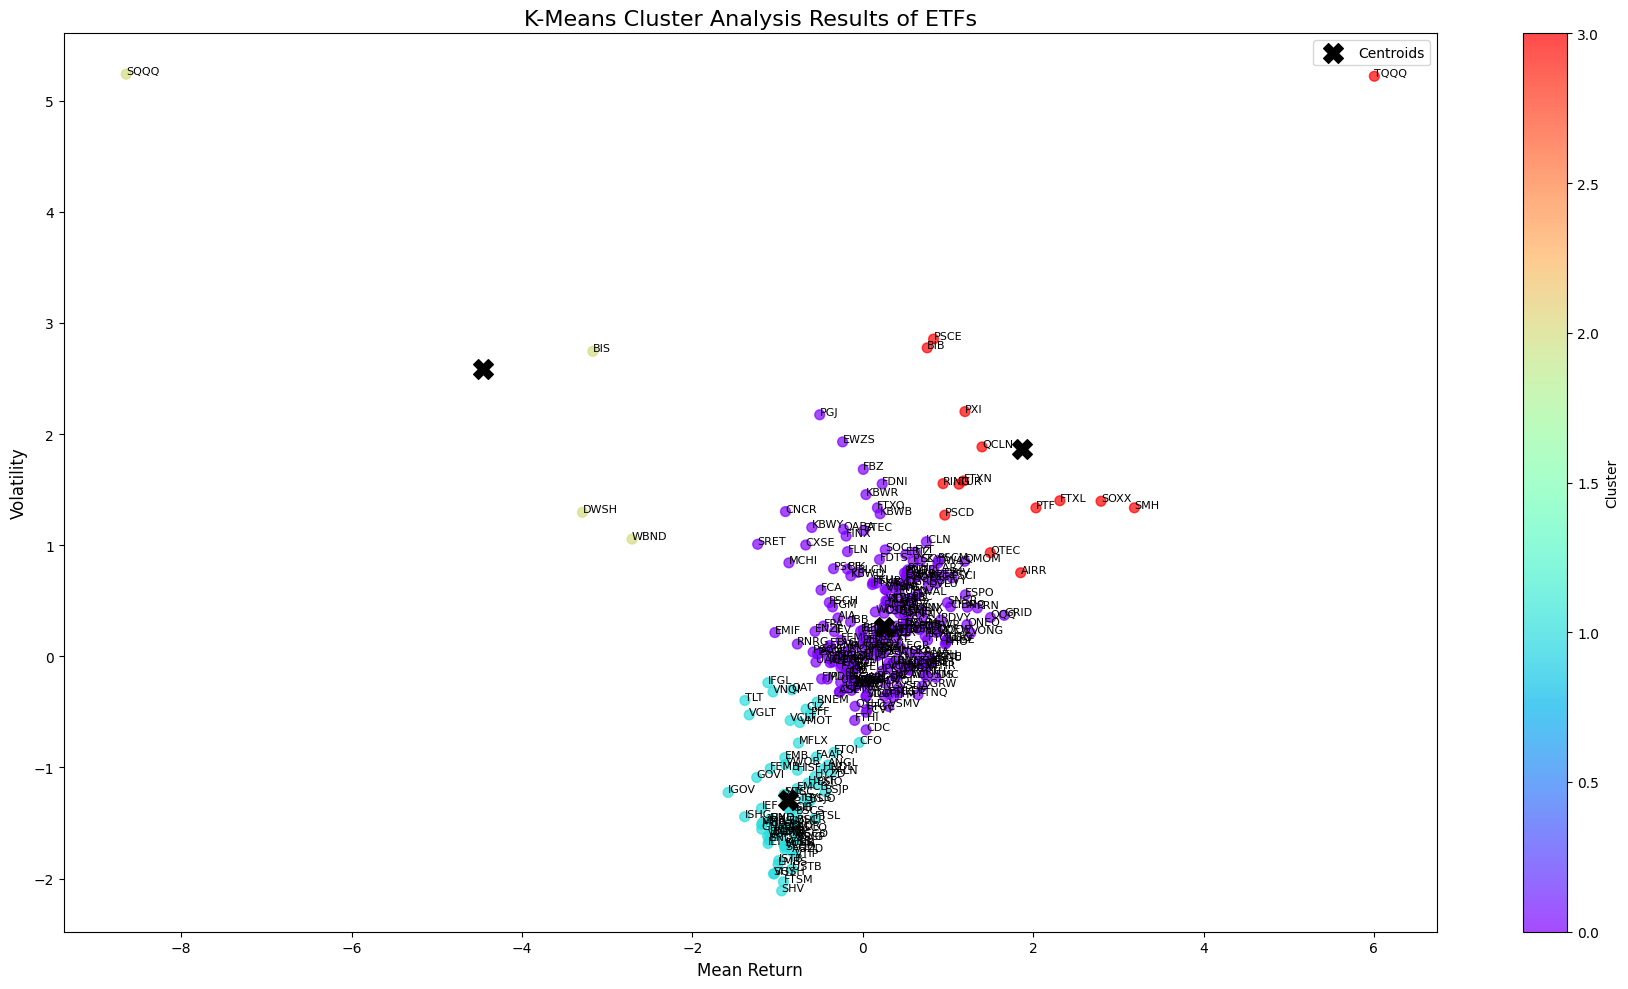

In [19]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

# Ensure we have the cluster information
X_predict = df_scaled.select(['Returns', 'Volatility']).to_numpy()
prediction = k_means.predict(X_predict)

# Add predictions to the original dataframe
df_scaled = df_scaled.with_columns(pl.Series(name='Cluster', values=prediction))

# Extract centroids
centroids = k_means.cluster_centers_

# Create the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Scatter plot of ETFs
scatter = ax.scatter(
    df_scaled['Returns'].to_numpy(),
    df_scaled['Volatility'].to_numpy(),
    c=df_scaled['Cluster'].to_numpy(),
    cmap='rainbow',
    alpha=0.7,
    s=50
)

# Plot centroids
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='black',
    s=200,
    marker='X',
    label='Centroids'
)

# Customize the plot
ax.set_title('K-Means Cluster Analysis Results of ETFs', fontsize=16)
ax.set_xlabel('Mean Return', fontsize=12)
ax.set_ylabel('Volatility', fontsize=12)
plt.colorbar(scatter, label='Cluster')
ax.legend()

# Add ETF labels
for i, etf in enumerate(df_scaled['ETF'].to_numpy()):
    ax.annotate(etf, (df_scaled['Returns'][i], df_scaled['Volatility'][i]), fontsize=8)

plt.tight_layout()
plt.show()

/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_60207/1274910081.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


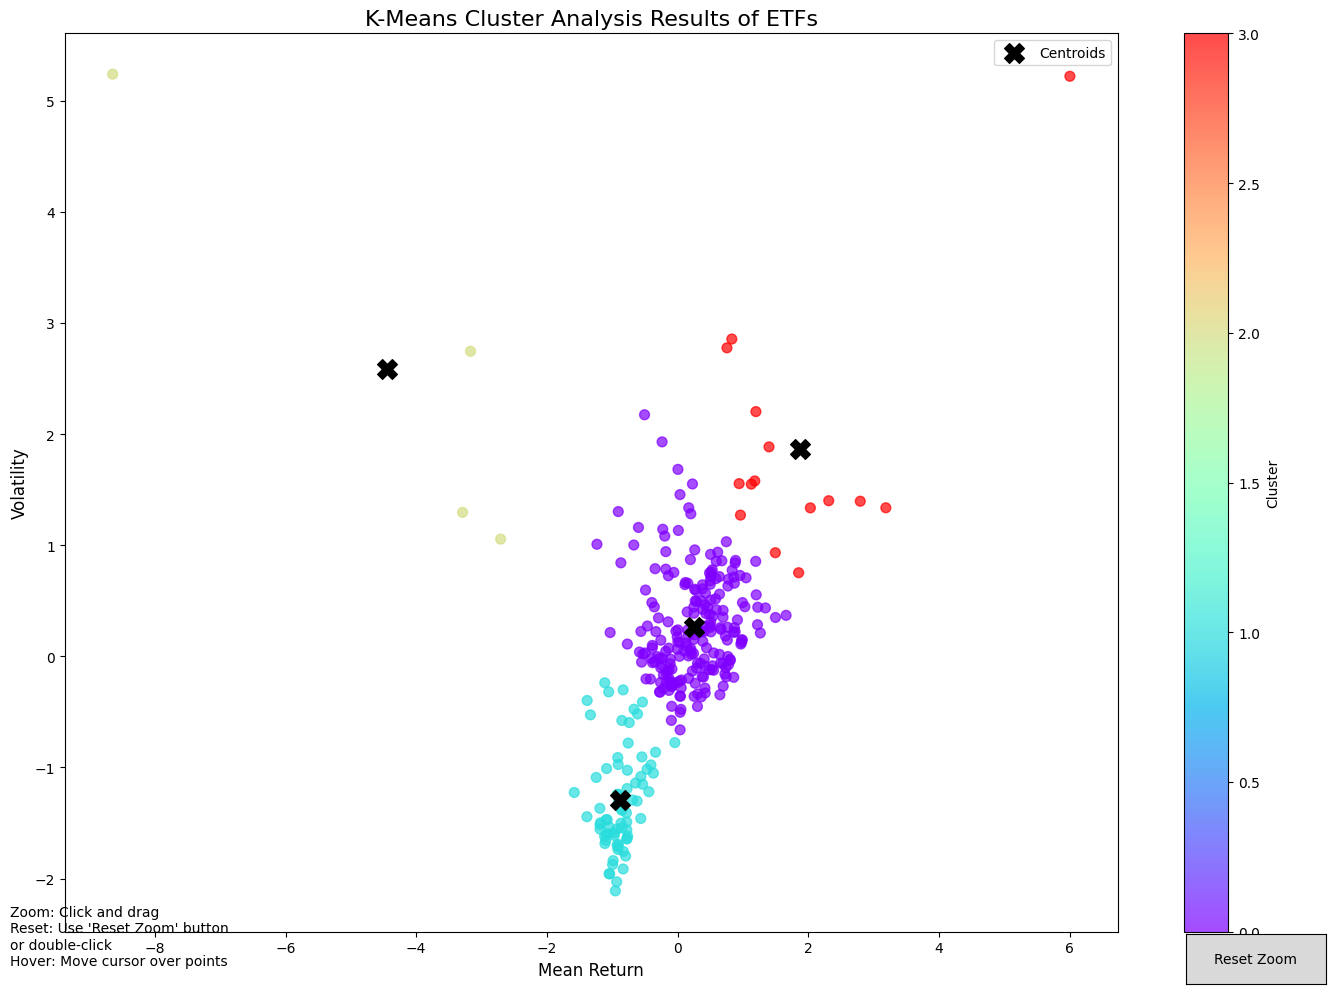

In [20]:
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, Button
import polars as pl
import numpy as np
import mplcursors

# Assuming df_scaled is your Polars DataFrame with the data
# and k_means is your fitted KMeans model

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot of ETFs
scatter = ax.scatter(
    df_scaled['Returns'].to_numpy(),
    df_scaled['Volatility'].to_numpy(),
    c=df_scaled['Cluster'].to_numpy(),
    cmap='rainbow',
    alpha=0.7,
    s=50
)

# Plot centroids
centroids = k_means.cluster_centers_
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='black',
    s=200,
    marker='X',
    label='Centroids'
)

# Customize the plot
ax.set_title('K-Means Cluster Analysis Results of ETFs', fontsize=16)
ax.set_xlabel('Mean Return', fontsize=12)
ax.set_ylabel('Volatility', fontsize=12)
plt.colorbar(scatter, label='Cluster')
ax.legend()

# Function to handle zooming
def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    ax.set_xlim(min(x1, x2), max(x1, x2))
    ax.set_ylim(min(y1, y2), max(y1, y2))
    fig.canvas.draw_idle()

# Function to reset zoom
def reset_zoom(event):
    ax.autoscale(True)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

# Set up RectangleSelector for zooming
rs = RectangleSelector(ax, line_select_callback, useblit=True,
                       button=[1],  # use only the main mouse button
                       minspanx=5, minspany=5,
                       spancoords='pixels',
                       interactive=True)

# Add a button for resetting zoom
reset_button_ax = fig.add_axes([0.85, 0.01, 0.1, 0.05])
reset_button = Button(reset_button_ax, 'Reset Zoom')
reset_button.on_clicked(reset_zoom)

# Add hover functionality
cursor = mplcursors.cursor(scatter, hover=True)

@cursor.connect("add")
def on_add(sel):
    i = sel.target.index
    etf = df_scaled['ETF'][i]
    returns = df_scaled['Returns'][i]
    volatility = df_scaled['Volatility'][i]
    cluster = df_scaled['Cluster'][i]
    sel.annotation.set_text(f"ETF: {etf}\nReturns: {returns:.4f}\nVolatility: {volatility:.4f}\nCluster: {cluster}")

# Add instructions to the plot
instructions = """
Zoom: Click and drag
Reset: Use 'Reset Zoom' button
or double-click
Hover: Move cursor over points
"""
fig.text(0.01, 0.01, instructions, fontsize=10, verticalalignment='bottom')

# Function to handle double click for resetting zoom
def on_double_click(event):
    if event.dblclick:
        reset_zoom(event)

fig.canvas.mpl_connect('button_press_event', on_double_click)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [21]:
import polars as pl

# Create a Polars DataFrame directly from the ETF names and cluster labels
df = pl.DataFrame({
    'ETF': df_scaled['ETF'],
    'Cluster': k_means.labels_.flatten()
})

# Keep the complete series (equivalent to clustered_series_all)
clustered_series_all = df

# Filter out rows where 'Cluster' is -1
clustered_series = df.filter(pl.col('Cluster') != -1)

# Display the first 15 entries of the filtered DataFrame
print(clustered_series.head(15))

# To display the entire unfiltered series
print(clustered_series_all.head(15))


shape: (15, 2)
┌──────┬─────────┐
│ ETF  ┆ Cluster │
│ ---  ┆ ---     │
│ str  ┆ i32     │
╞══════╪═════════╡
│ AADR ┆ 0       │
│ AAXJ ┆ 0       │
│ ACWI ┆ 0       │
│ ACWX ┆ 0       │
│ AGNG ┆ 0       │
│ …    ┆ …       │
│ ANGL ┆ 1       │
│ ASET ┆ 0       │
│ BBH  ┆ 0       │
│ BGRN ┆ 1       │
│ BIB  ┆ 3       │
└──────┴─────────┘
shape: (15, 2)
┌──────┬─────────┐
│ ETF  ┆ Cluster │
│ ---  ┆ ---     │
│ str  ┆ i32     │
╞══════╪═════════╡
│ AADR ┆ 0       │
│ AAXJ ┆ 0       │
│ ACWI ┆ 0       │
│ ACWX ┆ 0       │
│ AGNG ┆ 0       │
│ …    ┆ …       │
│ ANGL ┆ 1       │
│ ASET ┆ 0       │
│ BBH  ┆ 0       │
│ BGRN ┆ 1       │
│ BIB  ┆ 3       │
└──────┴─────────┘


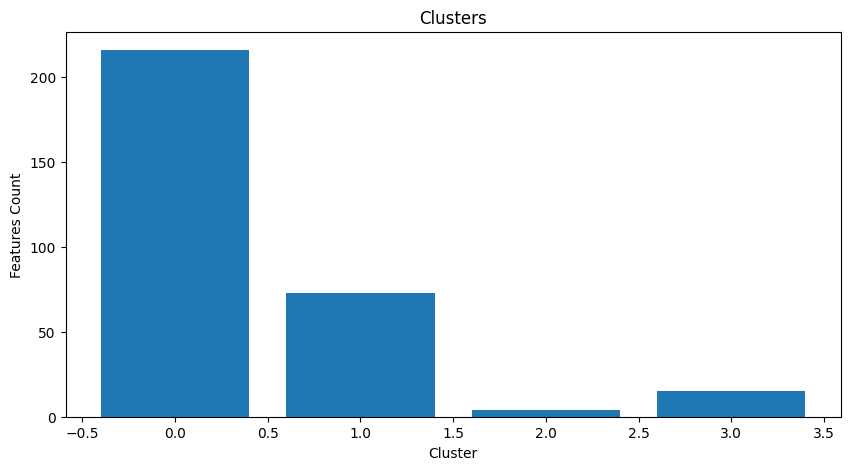

In [22]:
import matplotlib.pyplot as plt

# Calculate cluster counts
cluster_counts = clustered_series.get_column('Cluster').value_counts().sort('Cluster')

# Create the plot
plt.figure(figsize=(10, 5))
plt.bar(cluster_counts['Cluster'], cluster_counts['count'])  # Note: 'count' instead of 'counts'

# Set labels and title
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")

# Show the plot
plt.show()

In [23]:
# Remove items if preferred
clusters_clean = clustered_series.filter(pl.col('Cluster') > .5)

print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  308
Feature Number Current:  92


In [24]:
clusters_clean


ETF,Cluster
str,i32
"""AGZD""",1
"""AIRR""",3
"""ANGL""",1
"""BGRN""",1
"""BIB""",3
…,…
"""VRIG""",1
"""VTC""",1
"""VTIP""",1


# Calculating Cointegrated Pairs

In [25]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

def calculate_cointegration(series1, series2):
    """
    Calculates whether two financial assets are cointegrated, providing key parameters for pairs trading.
    
    Parameters:
    series1 (array-like): Price series of the first asset.
    series2 (array-like): Price series of the second asset.

    Returns:
    coint_flag (int): Indicates if the pair is cointegrated (1 if yes, 0 if no).
    hedge_ratio (float): Ratio used to hedge positions between the two assets.
    """

    # Perform cointegration test using statsmodels
    coint_res = coint(series1, series2)
    coint_t = coint_res[0]  # Test statistic
    p_value = coint_res[1]  # P-value of the test statistic
    critical_value = coint_res[2][1]  # 5% critical value

    # Conduct linear regression to determine the hedge ratio
    series1 = sm.add_constant(series1)  # Add a constant for the intercept
    model = sm.OLS(series2, series1).fit()
    hedge_ratio = model.params[1]  # Hedge ratio from the regression slope

    # Evaluate cointegration based on p-value and test statistic against critical value
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0

    # Notify the user that the cointegration calculation is complete
    print("Cointegration calculation complete. Cointegration Flag:", coint_flag, "Hedge Ratio:", hedge_ratio)

    return coint_flag, hedge_ratio


In [26]:
import polars as pl

def loop_through_and_calculate_cointegration(clusters_clean, data):
    tested_pairs = []
    cointegrated_pairs = []

    # Fetch the list of unique ETFs from the clusters_clean DataFrame
    etf_names = clusters_clean.get_column('ETF').to_list() # uses .to_list because polars has issues working with strings and numerics

    # Iterate over each ETF as the base asset
    for base_asset in etf_names:
        # Retrieve the cluster label for the base asset
        base_label = clusters_clean.filter(pl.col('ETF') == base_asset).select('Cluster').to_series()[0]

        # Iterate over each ETF again as the compare asset
        for compare_asset in etf_names:
            if base_asset != compare_asset:
                compare_label = clusters_clean.filter(pl.col('ETF') == compare_asset).select('Cluster').to_series()[0]

                # Only compare assets within the same cluster
                if base_label == compare_label:
                    # Create a sorted tuple of the pair to ensure uniqueness
                    test_pair = tuple(sorted((base_asset, compare_asset)))

                    if test_pair not in tested_pairs:
                        tested_pairs.append(test_pair)

                        # Access the time series data for both ETFs from the data DataFrame
                        # Extracting data for all dates (assuming data is already aligned)
                        series1 = data.get_column(base_asset).to_numpy().astype(float)
                        series2 = data.get_column(compare_asset).to_numpy().astype(float)

                        # Calculate cointegration; the function needs to be defined to accept these series
                        coint_flag, hedge_ratio = calculate_cointegration(series1, series2)

                        # If the assets are cointegrated, add them to the list of cointegrated pairs
                        if coint_flag == 1:
                            cointegrated_pairs.append({
                                "base_asset": base_asset,
                                "compare_asset": compare_asset,
                                "label": base_label
                            })

    # Create a DataFrame from the list of cointegrated pairs
    df_coint = pl.DataFrame(cointegrated_pairs)
    
    # Save the results to a CSV file for further analysis
    df_coint.write_csv('data/cointegrated_pairs.csv')
    print("Calculation and saving of cointegrated pairs complete.")

# Make sure to define or import your calculate_cointegration function that can handle these series.
import polars as pl

def loop_through_and_calculate_cointegration(clusters_clean, data):
    tested_pairs = []
    cointegrated_pairs = []

    # Fetch the list of ETFs from the clusters_clean DataFrame. This list is used to iterate over all possible pairs.
    etf_names = clusters_clean.get_column('ETF').to_list()

    # Iterate over each ETF as the base asset. The base asset will be paired with every other possible compare asset.
    for base_asset in etf_names:
        # Retrieve the cluster label for the base asset. Clustering ETFs often groups them by similar characteristics such as sector or volatility.
        base_label = clusters_clean.filter(pl.col('ETF') == base_asset).select('Cluster').to_series()[0]

        # Iterate over each ETF again to find a suitable compare asset.
        for compare_asset in etf_names:
            if base_asset != compare_asset:
                # Fetch the cluster label for the compare asset to ensure both assets are comparable.
                compare_label = clusters_clean.filter(pl.col('ETF') == compare_asset).select('Cluster').to_series()[0]

                # Only consider pairs within the same cluster to enhance the likelihood that they share similar economic or market dynamics.
                if base_label == compare_label:
                    # Create a sorted tuple to uniquely identify each pair, ensuring no duplicate pair analysis.
                    test_pair = tuple(sorted((base_asset, compare_asset)))

                    if test_pair not in tested_pairs:
                        tested_pairs.append(test_pair)

                        # Access the historical price series data for both ETFs. This is crucial for determining their statistical relationship over time.
                        series1 = data.get_column(base_asset).to_numpy().astype(float)
                        series2 = data.get_column(compare_asset).to_numpy().astype(float)

                        # Calculate cointegration to determine if the pair has a statistically significant long-term equilibrium relationship.
                        coint_flag, hedge_ratio = calculate_cointegration(series1, series2)

                        # If the assets are found to be cointegrated, it implies a stable long-term relationship where the spread between them is mean-reverting.
                        if coint_flag == 1:
                            cointegrated_pairs.append({
                                "base_asset": base_asset,
                                "compare_asset": compare_asset,
                                "label": base_label
                            })

    # Compile the findings into a DataFrame for easy analysis and storage.
    df_coint = pl.DataFrame(cointegrated_pairs)
    
    # Save the results to a CSV file for further analysis or for use in trading strategies.
    df_coint.write_csv('data/cointegrated_pairs.csv')
    print("Calculation and saving of cointegrated pairs complete.")

# Ensure that the calculate_cointegration function is defined in your environment.
# This function should be able to handle the price series and calculate the cointegration flag and hedge ratio.


In [27]:
print(clusters_clean.head())
print(data.head())


shape: (5, 2)
┌──────┬─────────┐
│ ETF  ┆ Cluster │
│ ---  ┆ ---     │
│ str  ┆ i32     │
╞══════╪═════════╡
│ AGZD ┆ 1       │
│ AIRR ┆ 3       │
│ ANGL ┆ 1       │
│ BGRN ┆ 1       │
│ BIB  ┆ 3       │
└──────┴─────────┘
shape: (5, 645)
┌─────────────────────┬───────────┬──────┬──────┬───┬──────┬───────────┬───────────┬─────┐
│ Date                ┆ AADR      ┆ AAPB ┆ AAPD ┆ … ┆ XFIX ┆ XT        ┆ YLDE      ┆ ZZZ │
│ ---                 ┆ ---       ┆ ---  ┆ ---  ┆   ┆ ---  ┆ ---       ┆ ---       ┆ --- │
│ str                 ┆ f64       ┆ str  ┆ str  ┆   ┆ str  ┆ f64       ┆ f64       ┆ str │
╞═════════════════════╪═══════════╪══════╪══════╪═══╪══════╪═══════════╪═══════════╪═════╡
│ 2019-01-02 00:00:00 ┆ 37.611717 ┆ 0    ┆ 0    ┆ … ┆ 0    ┆ 31.699696 ┆ 23.761587 ┆ 0   │
│ 2019-01-03 00:00:00 ┆ 37.192047 ┆ 0    ┆ 0    ┆ … ┆ 0    ┆ 30.861731 ┆ 23.422529 ┆ 0   │
│ 2019-01-04 00:00:00 ┆ 38.637581 ┆ 0    ┆ 0    ┆ … ┆ 0    ┆ 31.918715 ┆ 23.999847 ┆ 0   │
│ 2019-01-07 00:00:00 ┆ 39.094551

In [28]:
loop_through_and_calculate_cointegration(clusters_clean, data)


Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 1.8077136358886399
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: -1.167379264360854
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: -1.8809337078570885
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: -1.6087534506214716
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: -1.043951396357158
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 0.6717770684050937
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 0.4975117430907012
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 0.34224561595727626
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 0.2905035566462283
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 0.23376575197199126
Cointegration calculation complete. Cointegration Flag: 0 Hedge Ratio: 1.129719790978787
Cointeg

In [29]:
#Load Cointegrated Pairs
df_coint = pl.read_csv('data/cointegrated_pairs.csv')
df_coint.head()

base_asset,compare_asset,label
str,str,i64
"""AGZD""","""FTSM""",1
"""AGZD""","""SHV""",1
"""AGZD""","""VRIG""",1
"""BGRN""","""BNDW""",1
"""BGRN""","""BNDX""",1


In [30]:
df_coint


base_asset,compare_asset,label
str,str,i64
"""AGZD""","""FTSM""",1
"""AGZD""","""SHV""",1
"""AGZD""","""VRIG""",1
"""BGRN""","""BNDW""",1
"""BGRN""","""BNDX""",1
…,…,…
"""SUSB""","""VGSH""",1
"""SUSC""","""UITB""",1
"""UITB""","""USIG""",1
